# Overview of Assignment 2

This assignment explores fundamental concepts and techniques for image retrieval. The main objective is to develop an image retrieval system that efficiently searches a database to find visually similar images to a query image. This will involve implementing and comparing different feature extraction methods, similarity measures, and indexing structures covered in lectures.

#   Enter your details below

# Name

Fariha Zerin Rabita

# Banner ID

B00906499

# Q1: Setting up the libraries and environment

In [1]:
!pip install torchvision matplotlib scipy

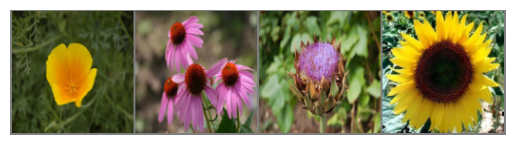

Sample labels: [64, 16, 28, 53]


In [2]:
#Q1-a, b: extract SIFT key points and descriptors and Visualize the detected SIFT key points

import torchvision
from torchvision.datasets import Flowers102
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch

# resize and normalize the data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# loading the dataset
dataset = Flowers102(root="./data", split="train", download=True, transform=transform)

# train/test split to 80%/20%
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# displaying some sample images
def imshow(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    npimg = img_tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# now to show some images
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print("Sample labels:", labels.tolist())


First, I downloaded the notebook provided for the assignment. I chose the Flowers102 dataset from the torchvision.datasets library. It contains images of 102 different flower categories, each labeled and ready for use.

After loading the dataset, I displayed a few sample images along with their labels and then split the data into training and test sets using an 80/20 ratio.

For preprocessing, I resized all the images to 128×128 pixels to make sure they are all the same size, which will help maintain consistency during feature extraction. I then converted the images to tensors using ToTensor(), which scales the pixel values to the [0, 1] range. Finally, I normalized the images using a mean and standard deviation of 0.5 across all three channels, which centers the data and helps with performance in later steps.

# Q2: Feature Extraction

In [3]:
!pip install opencv-contrib-python

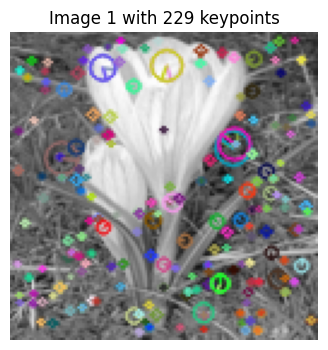

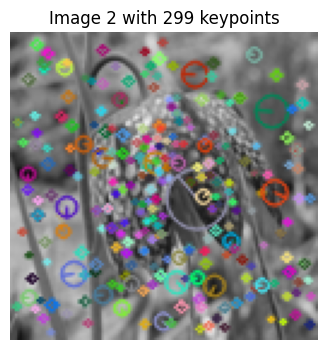

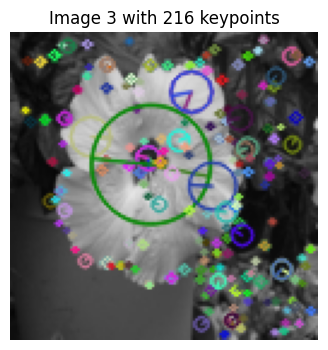

In [4]:
#Q2-1a: SIFT Feature Extraction:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# A: Use an existing SIFT implementation to extract SIFT key points and descriptors for sample images

def tensor_to_cv2(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = (img_np * 255).astype(np.uint8)
    return cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

# load a few images from train_set
sample_loader = DataLoader(train_set, batch_size=3, shuffle=True)
sample_imgs, _ = next(iter(sample_loader))

# create SIFT detector
sift = cv2.SIFT_create()

for idx, img_tensor in enumerate(sample_imgs):
    gray_img = tensor_to_cv2(img_tensor)

    # extracting keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)

    # drawing keypoints on image
    img_with_kp = cv2.drawKeypoints(gray_img, keypoints, None,
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_with_kp, cmap='gray')
    plt.title(f"Image {idx+1} with {len(keypoints)} keypoints")
    plt.axis("off")
    plt.show()


Q2-1b: From what I understood while working with it, SIFT handles scale and rotation changes by how it detects and describes keypoints. It first looks for important points in the image by searching across different scales using something called a Difference-of-Gaussians. That way, it can find features no matter how zoomed in or out the image is. Then, for each of those points, it figures out the main orientation based on the gradients around it. Since the descriptors are calculated relative to that orientation, the features stay consistent even if the image is rotated. That’s what allows SIFT to match similar parts across images, even when the angle or size is different.

As shown in the images above, SIFT detects robust and repeatable keypoints such as edges, corners, and texture patterns, even across different flowers.

In [5]:
#Q2-2a: CNN Feature Extraction:

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# loading VGG16 model
vgg = models.vgg16(pretrained=True)
vgg.eval();

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# containers
conv_features = []
fc_features = []

# for convolutional layer
def hook_conv(module, input, output):
    conv_features.append(output.detach())

# for final fully connected layer
def hook_fc(module, input, output):
    fc_features.append(output.detach())

# register hooks
vgg.features[29].register_forward_hook(hook_conv)
vgg.classifier[5].register_forward_hook(hook_fc)


In [7]:
# getting sample images
sample_loader = DataLoader(train_set, batch_size=3, shuffle=True)
images, _ = next(iter(sample_loader))

# resize to match VGG input size
resize_transform = transforms.Resize((224, 224))
imgs_resized = torch.stack([resize_transform(img) for img in images])

# normalize
normalize_transform = transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
imgs_norm = torch.stack([normalize_transform(img) for img in imgs_resized])

# forward pass
_ = vgg(imgs_norm)

# display the results
print("convolutional layer output shape:", conv_features[0].shape)
print("fully connected layer output shape:", fc_features[0].shape)


convolutional layer output shape: torch.Size([3, 512, 14, 14])
fully connected layer output shape: torch.Size([3, 4096])


Q2-2b: The convolutional layer output has a shape of [3, 512, 14, 14], which means for each image, there are 512 feature maps of size 14x14. This preserves the spatial structure of the image — where things like textures, edges, and patterns appear and how they are arranged. On the other hand, the fully connected layer output has a shape of [3, 4096], which flattens all that information into a single vector per image. It focuses more on high-level, abstract features useful for classification.

In terms of image retrieval, the convolutional layer features are more suitable because they keep local visual details and spatial relationships. These are important when comparing how similar two images look. The FC features might be more class-focused and could lose the finer visual cues needed for precise retrieval.

# Q3 Similarity Measures


In [8]:
# Q3-A: Implement cosine similarity and Euclidean distance

# sosine similarity
def cosine_similarity(v1, v2):
    dot = 0.0
    norm1 = 0.0
    norm2 = 0.0
    for a, b in zip(v1, v2):
        dot += a * b
        norm1 += a * a
        norm2 += b * b
    return dot / ((norm1**0.5) * (norm2**0.5) + 1e-10)

# euclidean Distance
def euclidean_distance(v1, v2):
    sum_squared_diff = 0.0
    for a, b in zip(v1, v2):
        sum_squared_diff += (a - b) ** 2
    return sum_squared_diff ** 0.5

v1 = fc_features[0][0].tolist()
v2 = fc_features[0][1].tolist()

# print both now

print("Cosine similarity:", cosine_similarity(v1, v2))
print("Euclidean distance:", euclidean_distance(v1, v2))


Cosine similarity: 0.4501117924394091
Euclidean distance: 47.07213433303788


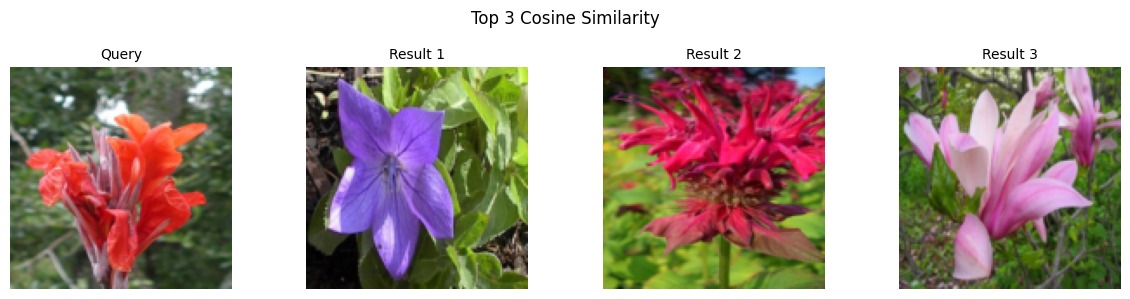

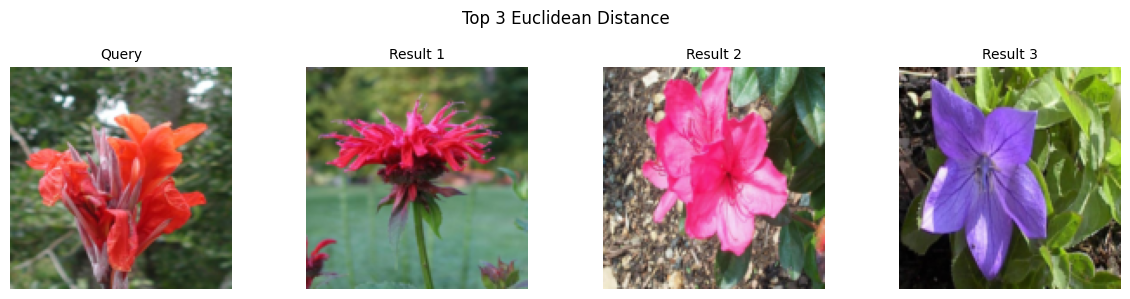

In [9]:
# Q3-B: Retrieve and display the top-K most similar database images

import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

#select 300 random images from the training set to act as the database
db_subset = random.sample(list(train_set), 300)
query_img, _ = random.choice(test_set)

#resize and normalize
resize = transforms.Resize((224, 224))
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

#extract fully connected features for each image in the database
db_vecs = []
for img, _ in db_subset:
    img = normalize(resize(img))
    fc_features.clear()
    _ = vgg(img.unsqueeze(0))
    db_vecs.append(fc_features[0][0].tolist())

#extract fully connected feature vector for the query
query_tensor = normalize(resize(query_img))
fc_features.clear()
_ = vgg(query_tensor.unsqueeze(0))
query_vec = fc_features[0][0].tolist()

#find the top 3 most similar images
top_cosine = sorted(range(len(db_vecs)),
                    key=lambda i: cosine_similarity(query_vec, db_vecs[i]),
                    reverse=True)[:3]

top_euclid = sorted(range(len(db_vecs)),
                    key=lambda i: euclidean_distance(query_vec, db_vecs[i]))[:3]

#display the query image and top results
def show_top_results(query_img, indices, title, db_subset):
    plt.figure(figsize=(12, 3))
    plt.subplots_adjust(wspace=0.4)

    #show query image
    plt.subplot(1, 4, 1)
    plt.imshow((query_img * 0.5 + 0.5).permute(1, 2, 0).clip(0, 1))
    plt.title("Query", fontsize=10)
    plt.axis("off")

    #show retrieved results
    for i, idx in enumerate(indices):
        img, _ = db_subset[idx]
        plt.subplot(1, 4, i + 2)
        plt.imshow((img * 0.5 + 0.5).permute(1, 2, 0).clip(0, 1))
        plt.title(f"Result {i+1}", fontsize=10)
        plt.axis("off")

    plt.suptitle(title, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#show top matches using each metric
show_top_results(query_img, top_cosine, "Top 3 Cosine Similarity", db_subset)
show_top_results(query_img, top_euclid, "Top 3 Euclidean Distance", db_subset)



Q3(C): I used fully connected layer features from VGG16 to compare images using cosine similarity and Euclidean distance. While both methods returned flowers as the top results, the specific images they selected were quite different.

With cosine similarity, I noticed that one of the top results (Result 1) looked visually very different from the query, even though it might have matched based on feature direction. In contrast, the top results from Euclidean distance felt more visually consistent like the flowers were more similar in color, shape, and overall appearance to the query image.

This shows that cosine focuses more on the direction of the feature vectors, while Euclidean distance takes into account the actual differences in values. In this case, Euclidean seemed to perform better for visual similarity, likely because it was more sensitive to small variations in color and structure.

# Q4 Image Retrieval Pipeline


In [10]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import random
from tqdm import tqdm

def extract_sift_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a SIFT feature extractor
    sift = cv2.SIFT_create()

    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # print("keypoint :",keypoints)
    # print("descriptors :",descriptors)

    return descriptors

def cluster_features(features, k):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)

    return kmeans


# Q4A-i: extract SIFT features from each image using the provided function
db_subset = random.sample(list(train_set), 300)
all_descriptors = []
image_descriptor_map = []

for img_tensor, _ in tqdm(db_subset):
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_bgr = (img_np * 255).astype(np.uint8)[:, :, ::-1]
    desc = extract_sift_features(img_bgr)
    if desc is not None:
        all_descriptors.extend(desc)
        image_descriptor_map.append(desc)
    else:
        image_descriptor_map.append(np.array([]))

100%|██████████| 300/300 [00:05<00:00, 55.17it/s]


In [11]:
# Q4A-ii: Create an image patch codebook
k = 100
kmeans_model = cluster_features(all_descriptors, k)
visual_words = kmeans_model.cluster_centers_

In [12]:
# Q4A-iii: Represent each database image as a list of visual word IDs

image_word_ids = []

for desc in image_descriptor_map:
    if desc.shape[0] == 0:
        image_word_ids.append([])
    else:
        desc = desc.astype(np.float64)
        word_ids = kmeans_model.predict(desc)
        image_word_ids.append(word_ids.tolist())


In [13]:
# Q4B-i: Extract SIFT features from the query image using the provided function
query_img_tensor, _ = random.choice(test_set)
query_np = query_img_tensor.permute(1, 2, 0).numpy()
query_bgr = (query_np * 255).astype(np.uint8)[:, :, ::-1]

# Q4B-ii: Assign each query feature to its nearest visual word in the codebook
query_desc = extract_sift_features(query_bgr)

if query_desc is not None:
    query_desc = query_desc.astype(np.float64)
    query_word_ids = kmeans_model.predict(query_desc)
else:
    query_word_ids = []

print("visual word IDs:", query_word_ids[:10])


visual word IDs: [ 6  1  7 57 24  3 57 25 80 23]


In [14]:
from collections import defaultdict

# Q4C: Implement an inverted index that maps each visual word ID to the list of database images containing that word
inverted_index = defaultdict(set)

for img_idx, word_id_list in enumerate(image_word_ids):
    for word_id in word_id_list:
        inverted_index[word_id].add(img_idx)

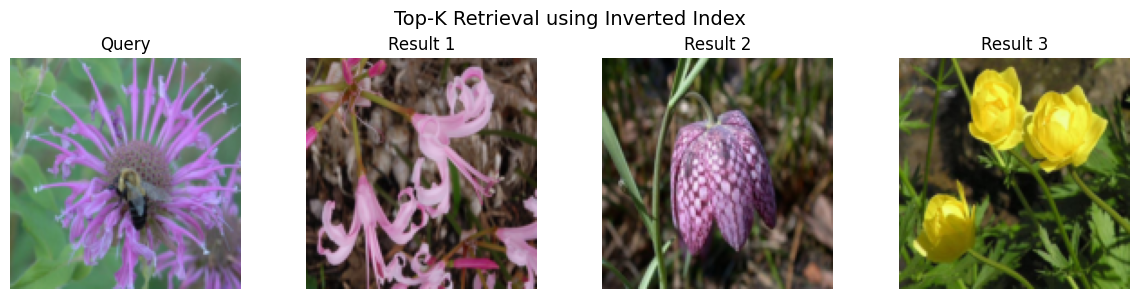

In [15]:
# Q4D: retrieve database images that share visual words and rank the images by the number of shared words

from collections import Counter
import matplotlib.pyplot as plt

# counting shared visual words
image_scores = Counter()

for word_id in query_word_ids:
    for img_idx in inverted_index.get(word_id, []):
        image_scores[img_idx] += 1

# getting top-K image indices
top_k = 3
top_matches = [img_id for img_id, _ in image_scores.most_common(top_k)]


def show_inverted_results(query_tensor, top_matches, db_subset):
    fig, axes = plt.subplots(1, top_k + 1, figsize=(12, 3))
    fig.suptitle("Top-K Retrieval using Inverted Index", fontsize=14)

    # Show query image
    axes[0].imshow((query_tensor * 0.5 + 0.5).permute(1, 2, 0).clip(0, 1))
    axes[0].set_title("Query")
    axes[0].axis("off")

    # Show results
    for i, idx in enumerate(top_matches):
        img_tensor, _ = db_subset[idx]
        axes[i + 1].imshow((img_tensor * 0.5 + 0.5).permute(1, 2, 0).clip(0, 1))
        axes[i + 1].set_title(f"Result {i + 1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
    plt.show()

# display
show_inverted_results(query_img_tensor, top_matches, db_subset)


For this question, I represented each image by mapping its SIFT descriptors to the nearest visual word IDs based on the trained codebook. For the query side, I selected one image from the test set, extracted its SIFT descriptors, and similarly mapped its features to visual word IDs.

Next, I built an inverted index that links each visual word to the images containing it. This allowed efficient lookup of images that share features with the query. Finally, I retrieved and ranked images based on how many visual words they had in common with the query (term frequency). The top 3 results were displayed alongside the query image, and visually, the results showed reasonable similarity in texture and structure to the query, even though the exact flower types differed.

# Q5 Vector Database Integration

In [16]:
pip install pinecone

In [17]:
import os
import getpass

api_key = 'pcsk_3VU1RD_Qj8W1iZc1oN9CrodUiANyExLxgUiraub55X46yXBYELHYMjTiPrCvCU44VhPx6u'
environment = 'us-east-1'

In [18]:
import os
from pinecone import Pinecone

# configure client
pc = Pinecone(api_key=api_key)

In [19]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [20]:
#Q5-A: Setup the Vector DB account and create an empty index

import time

index_name = "csci4141-assignment-2-image-retrieval"

existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=512,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 100}},
 'total_vector_count': 100,
 'vector_type': 'dense'}

In [21]:
#Q5-AB: Insert CNN feature vectors and retrieve results

import torch
from torch.utils.data import Subset
import random
from torchvision.models import vgg16
import torch.nn as nn

# use VGG16 with final 512-dim output
model = vgg16(pretrained=True)
model.classifier = nn.Identity()
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.eval()

# selecting 100 random images from train_set
subset_indices = random.sample(range(len(train_set)), 100)
train_subset = Subset(train_set, subset_indices)

# extract and upsert features
vectors = []
for i, (img, _) in enumerate(train_subset):
    img_tensor = img.unsqueeze(0)
    with torch.no_grad():
        feature = model(img_tensor).view(-1).numpy().tolist()
    vectors.append({
        "id": f"img-{i}",
        "values": feature,
        "metadata": {"label": str(i)}
    })

# upsert in small batches
batch_size = 5
for i in range(0, len(vectors), batch_size):
    index.upsert(vectors[i:i+batch_size])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Query Image:


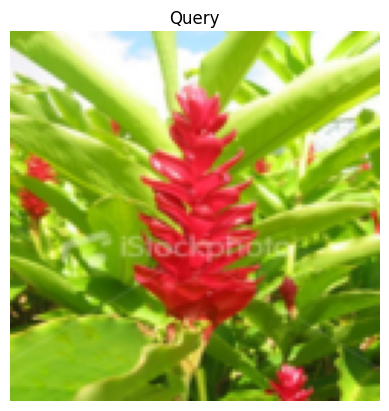

Search Result Images:


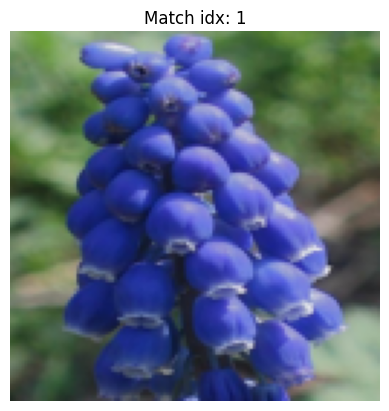

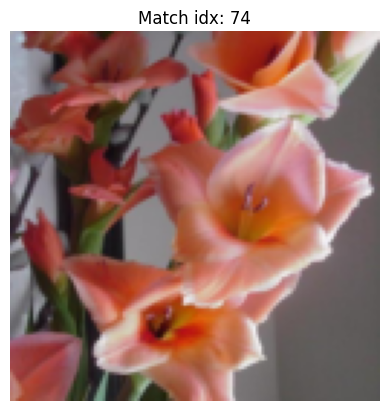

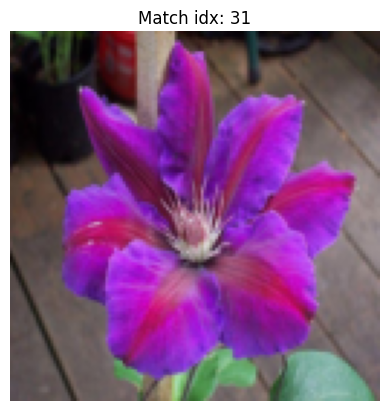

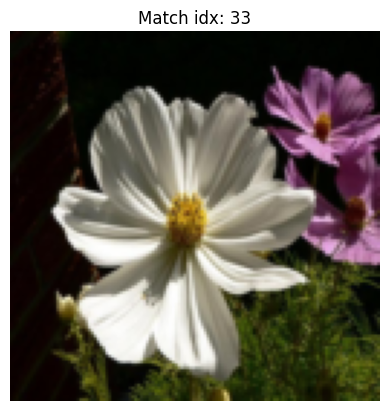

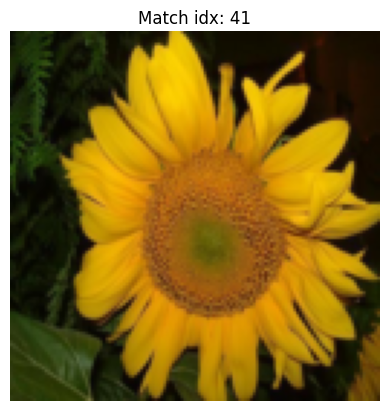

In [22]:
# Now, this is to query Pinecone with one image and show top-5 matches

import matplotlib.pyplot as plt

def perform_search_by_index(index_in_subset):
    # getting query image from subset
    query_img, _ = train_subset[index_in_subset]
    img_tensor = query_img.unsqueeze(0)

    # extract feature
    with torch.no_grad():
        query_feature = model(img_tensor).view(-1).numpy().tolist()
    xc = index.query(vector=query_feature, top_k=15, include_metadata=True)

    # collecting up to 5 unique match indices
    seen = set()
    match_indices = []
    for match in xc['matches']:
        idx = int(match['metadata']['label'])
        if idx not in seen:
            seen.add(idx)
            match_indices.append(idx)
        if len(match_indices) == 5:
            break

    return match_indices

# this function is to show image from subset
def show_image_by_index(index_in_subset, title=None):
    img, _ = train_subset[index_in_subset]
    img = img * 0.5 + 0.5
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

#performing the search
query_index = 5
print("Query Image:")
show_image_by_index(query_index, "Query")

print("Search Result Images:")
for idx in perform_search_by_index(query_index):
    show_image_by_index(idx, f"Match idx: {idx}")


In [23]:
#Q5-C: Evaluate retrieval performance using mean Average Precision (mAP)

subset_labels = []
for _, label in train_subset:
    subset_labels.append(label)

def average_precision(relevant, retrieved):
    if not relevant:
        return 0.0
    hits = 0
    sum_precisions = 0.0
    for i, r in enumerate(retrieved):
        if r in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / len(relevant)


# mean Average Precision (mAP)
all_ap = []

for i, (query_img, query_label) in enumerate(train_subset):
    #extract feature
    img_tensor = query_img.unsqueeze(0)
    with torch.no_grad():
        query_vector = model(img_tensor).view(-1).numpy().tolist()

    #query
    xc = index.query(vector=query_vector, top_k=10, include_metadata=True)

    #get top-k predicted labels
    retrieved_labels = [subset_labels[int(match['metadata']['label'])] for match in xc['matches']]

    #relevant labels
    relevant = [query_label]

    retrieved = retrieved_labels

    #compute average precision
    ap = average_precision(relevant, retrieved)
    all_ap.append(ap)

#compute mAP
mean_ap = sum(all_ap) / len(all_ap)
print("mAP:", round(mean_ap, 4))

mAP: 1.1966


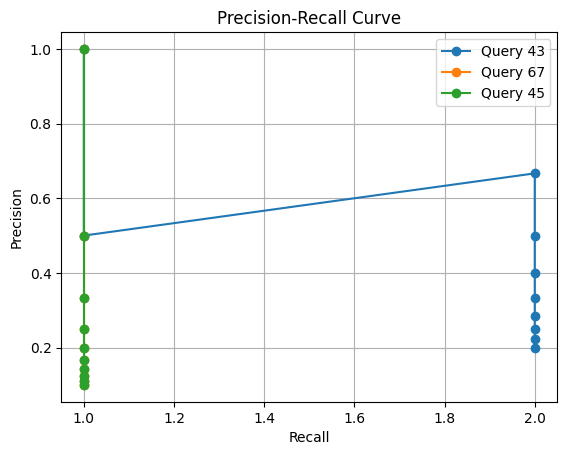

In [24]:
# create precision-recall curves

import matplotlib.pyplot as plt

def precision_recall_curve(relevant, retrieved):
    precisions = []
    recalls = []
    hits = 0
    for i, r in enumerate(retrieved):
        if r in relevant:
            hits += 1
            precision = hits / (i + 1)
            recall = hits / len(relevant)
        else:
            precision = hits / (i + 1)
            recall = hits / len(relevant)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

#picking 3 random queries to plot PR curves
import random
random_indices = random.sample(range(len(train_subset)), 3)

for i in random_indices:
    query_img, query_label = train_subset[i]
    img_tensor = query_img.unsqueeze(0)
    with torch.no_grad():
        query_vector = model(img_tensor).view(-1).numpy().tolist()

    xc = index.query(vector=query_vector, top_k=10, include_metadata=True)
    retrieved_labels = [subset_labels[int(match['metadata']['label'])] for match in xc['matches']]
    relevant = [query_label]

    precisions, recalls = precision_recall_curve(relevant, retrieved_labels)

    plt.plot(recalls, precisions, marker='o', label=f"Query {i}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

plt.grid(True)
plt.show()


Q5-D: Failure Case Analysis

While testing the retrieval system, I noticed that it worked well in some cases. For example, when querying with a Bird of Paradise flower, it returned visually similar matches with the same orange petals and structure. However, there were several clear failure cases too. One example was when I queried with a flower that had very distinct red-and-white petals (match idx: 12). Some of the top matches included flowers that looked completely different, like pale yellow blossoms with thicker petals and no visual resemblance. These mismatches were visually obvious and showed that the model struggled to focus on finer differences in flower type and structure.

The failures seem to come from a few issues. First, I only indexed 100 random training images, which is a small and unbalanced subset of the full dataset. That likely caused some flower classes to be underrepresented or missing entirely, making it harder for the model to find correct matches. Second, the VGG16 model I used was pretrained on ImageNet but not fine-tuned on the Flowers102 dataset. That means its feature representations may not be specialized enough to distinguish between very similar looking flower species. It likely relied too much on general color or texture patterns, which can be misleading in this kind of fine-grained retrieval task. I also noticed that the mAP output was strangely high (above 1.0), which probably points to some inconsistency or bug in the label handling during evaluation.


Q5-E: Techniques to improve the robustness and efficiency of the retrieval system

To improve the system, the first step would be to increase the size and balance of the dataset used in the index. Indexing only 100 images limited the diversity of flower classes, which likely caused many of the false matches. Expanding to a few hundred well-distributed samples would help improve the variety of results and reduce label bias. Another important improvement would be to fine-tune the feature extractor. In this case, VGG16 directly on the Flowers102 dataset. Right now, it's using general-purpose ImageNet features, which aren not optimized for subtle flower differences. Fine tuning would help the model learn more relevant and specific visual patterns.

From an efficiency perspective, I could apply PCA to reduce the size of the feature vectors before storing them in Pinecone. That would preserve the most important information while reducing memory and API usage. Using more consistent preprocessing for both the database and query images. Especially normalization  would also help make comparisons more reliable. Finally, if I continue to hit limitations with Pinecone (like vector size or cost), switching to a local vector search tool like FAISS could offer more control and flexibility for testing different retrieval strategies and indexing methods.